In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

titanic = pd.read_csv("train.csv")
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S


In [2]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [3]:
titanic["Cabin"].isnull().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

In [4]:
# Since there're many missing values for Cabin, we can drop it from analysis
titanic = titanic.drop(["Cabin"], axis=1)

In [5]:
# Create family size and drop columns SibSp, Parch, PassengerId, and Ticket
titanic["Family size"] = titanic["SibSp"] + titanic["Parch"] + 1
titanic = titanic.drop(['SibSp','Parch', 'PassengerId', 'Ticket'], axis=1)

In [6]:
titanic.head(3)

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Family size
0,0,3,"Braund, Mr. Owen Harris",male,22,7.2500,S,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,71.2833,C,2
2,1,3,"Heikkinen, Miss. Laina",female,26,7.9250,S,1


In [7]:
#=====================VISUALIZE AND ANALYZE EACH FEATURE======================================
# EMBARKED AND SEX
titanic["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
titanic["Embarked"].isnull().value_counts()

False    889
True       2
Name: Embarked, dtype: int64

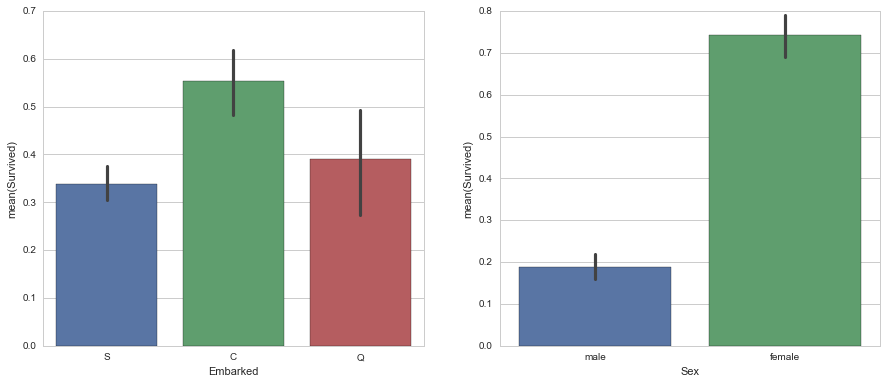

In [9]:
# We can replace missing values in Embarked for the most common value 'S'
titanic["Embarked"] = titanic["Embarked"].fillna("S")

# Visualize Embarked and Sex vs Survival
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot('Embarked','Survived', data=titanic, ax=axis1)
sns.barplot('Sex','Survived', data=titanic, ax=axis2)

In [10]:
# Embarked C has the highest rate of survival, as same as female gender
# Convert Male/Female to 0/1
titanic.loc[titanic["Sex"] == 'male', "Sex"] = 0
titanic.loc[titanic["Sex"] == 'female', "Sex"] = 1

# Convert Embarked, drop S, create 2 columns C and Q
pd.crosstab(titanic["Embarked"], titanic["Survived"])
embark = pd.get_dummies(titanic["Embarked"])
embark = embark.drop(["S"], axis=1)
titanic = titanic.join(embark)
titanic = titanic.drop(["Embarked"], axis=1)
titanic.head(3)

,Survived,Pclass,Name,Sex,Age,Fare,Family size,C,Q
0,0,3,"Braund, Mr. Owen Harris",0,22,7.2500,2,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,71.2833,2,1,0
2,1,3,"Heikkinen, Miss. Laina",1,26,7.9250,1,0,0


In [11]:
# TITLES
# Function to extract titles from 'Name'
import re
def title(name):
    title = re.search(' ([A-Za-z]+)\.', name)
    return title.group(1)

titanic["Title"] = titanic["Name"].apply(title)
# Doing analysis on average age of each title
titles_average_age = titanic[["Age", "Title"]].groupby("Title").mean()

In [12]:
titles_average_age

,Age
Title,
Capt,70.000000
Col,58.000000
Countess,33.000000
Don,40.000000
Dr,42.000000
Jonkheer,38.000000
Lady,48.000000
Major,48.500000
Master,4.574167


In [13]:
# Fill NaN values in Age according to their titles
titanic["Age"].fillna(value=0, inplace=True)
def filling_na_age(row):
    if row["Age"] == 0:
        row["Age"] = titles_average_age.loc[row["Title"],]
    return row
    
titanic= titanic.apply(filling_na_age, axis=1)
titanic["Age"] = titanic["Age"].astype(int)

# Create table of survived vs Titles
table = pd.crosstab(titanic["Survived"],titanic["Title"])
table

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Survived,,,,,,,,,,,,,,,,,
0,1,1,0,1,4,1,0,1,17,55,0,0,436,26,0,6,0
1,0,1,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1


[(0, 1.1)]

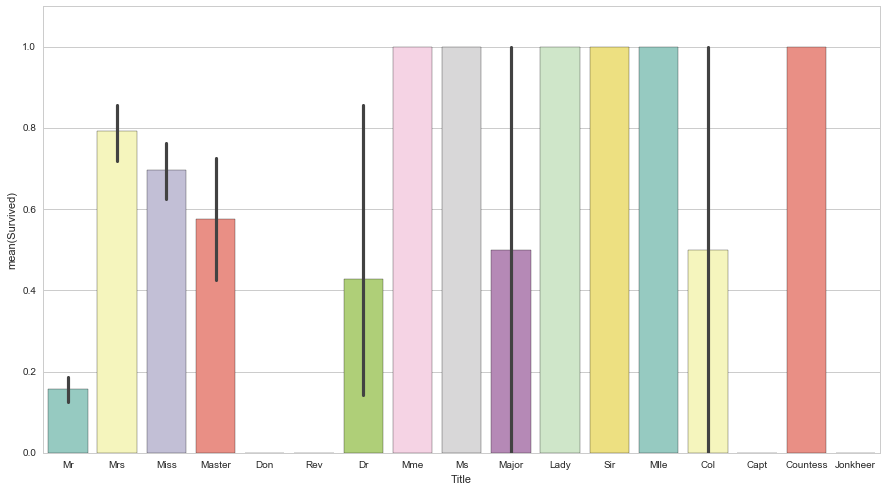

In [14]:
# There seems to have 3 separate groups:
# Type 1: Capt, Don, Jonkheer, Rev : 0   Mr: 81/517  Little chance of survival
# Type 2: Col, Major : 0.5 Dr: 3/7, Master: 23/40    Half chance of survival
# Type 3: Countess, Lady, Mme, Mlle, Sir, Ms : 1.0, Miss: 127/185  Mrs Highest chance of survival

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.barplot(titanic["Title"], titanic["Survived"],palette="Set3", label = "Survived rate per title")
ax.set(ylim=(0,1.1))

In [15]:
# Create a map of titles to map each title to either 1 of 3 types above
titles_map = {}
for k in ["Capt","Don","Jonkheer", "Rev", "Mr"]:
    titles_map[k] = 1
for k in ["Col","Major","Dr","Master"]: 
    titles_map[k] = 2
for k in ["Countess","Lady","Mme","Mlle","Sir","Ms", "Miss","Mrs"]:
    titles_map[k] = 3
    
titles = titanic["Title"]

for k,v in titles_map.items():
    titles[titles== k] = v    

# Drop the Type 1 which has the lowest chance of survival , and create 2 columns for Type 2 and 3
titles = pd.get_dummies(titles)
titles = titles.drop([1], axis=1)
titles.columns = ["Titles group 2", "Titles group 3"]
titanic = titanic.join(titles)
titanic = titanic.drop(["Title", "Name"], axis=1)
titanic.head(3)

C:\Users\Hanh\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Survived,Pclass,Sex,Age,Fare,Family size,C,Q,Titles group 2,Titles group 3
0,0,3,0,22,7.2500,2,0,0,0,0
1,1,1,1,38,71.2833,2,1,0,0,1
2,1,3,1,26,7.9250,1,0,0,0,1


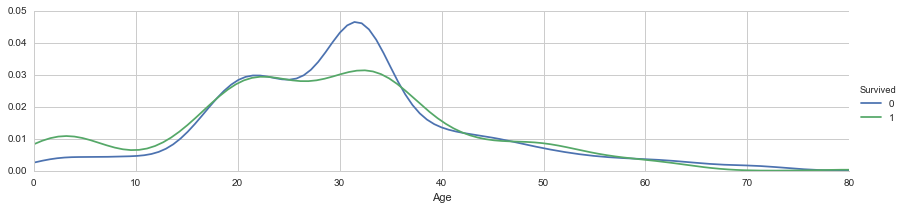

In [16]:
# AGE

# Graphing Age
g = sns.FacetGrid(titanic, hue="Survived", aspect = 4)
g.map(sns.kdeplot, "Age")
g.set(xlim=(0, titanic["Age"].max()))
g.add_legend()


In [17]:
# From the graph, Surived 1 line is higher for Age below 16-17
titanic.loc[titanic["Age"] < 16, "Survived"].mean()

0.5862068965517241

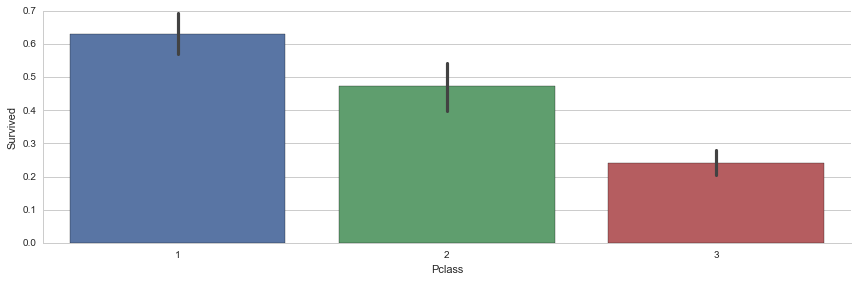

In [18]:
#Survived change is high for age below 16. Thus convert 'Age' columns to 1/0 based on threshold 16
titanic.loc[titanic["Age"] <= 16,"Age"] = 1
titanic.loc[titanic["Age"] > 16, "Age"] = 0

# PCLASS 
sns.factorplot('Pclass', 'Survived', data=titanic, kind='bar', aspect =3, size=4)

In [19]:
# Pclass 1 and 2 have the highest survival rate, so we can drop Pclass 3 and create 2 columns for P1 and P2
pclass = pd.get_dummies(titanic["Pclass"])
pclass = pclass.drop([3], axis=1)
pclass.columns = ["P1","P2"]
titanic = titanic.drop(["Pclass"], axis=1)
titanic = titanic.join(pclass)

In [20]:
# FARE
pd.DataFrame([titanic.loc[titanic["Fare"] > titanic["Fare"].mean(), "Survived"].mean(),
             titanic.loc[titanic["Fare"] < titanic["Fare"].mean(), "Survived"].mean()])

,0
0,0.597156
1,0.317647


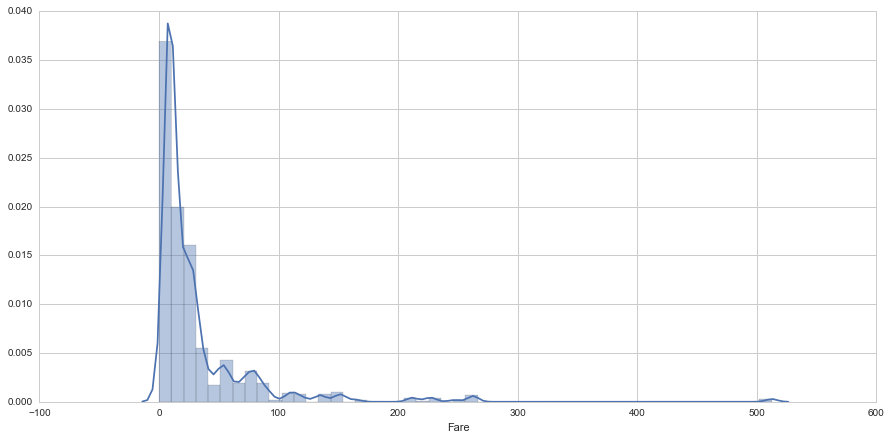

In [21]:
plt.figure(figsize=(15,7))
sns.distplot(titanic["Fare"])

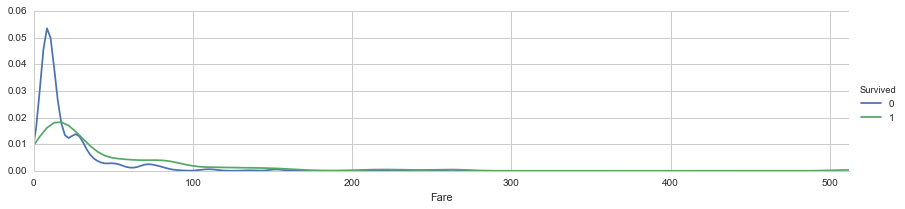

In [22]:
# Fare variable is pretty skewed with outliner at ~500, with higher survival chance appears above ~20
g = sns.FacetGrid(titanic, hue="Survived", aspect = 4)
g.map(sns.kdeplot, "Fare")
g.set(xlim=(titanic["Fare"].min(), titanic["Fare"].max()))
g.add_legend()

In [24]:
# Running some tests
#========================DEFINE TEST/TRAIN==============================
X = titanic.drop(["Survived"], axis=1)
y = titanic["Survived"]
from sklearn import cross_validation 

#=======================LINEAR REGRESSION===============================0.411
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
scores = cross_validation.cross_val_score(linreg, X, y, cv = 3)
print (scores.mean())

0.410823937656


In [25]:
#=====================LOGISTIC REGRESSION===============================
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
scores = cross_validation.cross_val_score(logreg, X, y, cv = 3)
print(scores.mean())   

0.817059483726


In [26]:
#=====================RANDOM FOREST=====================================
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1, n_estimators = 150, min_samples_split=7,
                             min_samples_leaf=2)
scores = cross_validation.cross_val_score(rf, X, y, cv=3)
print(scores.mean())

0.828282828283


In [27]:
#===================SUPPORT VECTOR MACHINE=============================
from sklearn.svm import SVC
svm = SVC()
scores = cross_validation.cross_val_score(svm, X, y, cv=3)
print(scores.mean())


0.773288439955


In [28]:
#===================ENSEMBLING AND GRADIENT BOOSTING=================
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold

algs = [GradientBoostingClassifier(random_state=1, n_estimators = 10, max_depth=3),
        LogisticRegression(random_state=1)]

# Using cross validation folds, generate indices for train, test
kf = KFold(titanic.shape[0], random_state=1 , n_folds=3)

predictions = []
for train, test in kf:
    X_train = X.iloc[train,:]
    y_train = y.loc[train]
    X_test = X.iloc[test,:]
    combine_predict =[]
    for alg in algs:
        alg.fit(X_train, y_train)
        predict = alg.predict_proba(X_test.astype(float))[:,1]
        combine_predict.append(predict)
    
    p = (combine_predict[0]*2+combine_predict[1])/3
    p[p<=0.5] = 0
    p[p>0.5] = 1
    predictions.append(p)

predictions = np.concatenate(predictions, axis=0)

accuracy = sum(predictions[predictions ==titanic["Survived"]]) / len(predictions)
print("Accuracy: {0}".format(accuracy))

Accuracy: 0.8294051627384961


C:\Users\Hanh\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
